In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data

C:\Users\Shin\Anaconda3\envs\tensorflow_windows\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setting up the basics

In [5]:
mnist = input_data.read_data_sets('./inputs/mnist')
# Resetting default graph, starting from scratch
tf.reset_default_graph()

epochs = 6000
batch_size = 64
n_noise = 200
learning_rate=0.00015

real_images = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='real_images')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])

# The keep_prob variable will be used by our dropout layers, which we introduce for more stable learning outcome
keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

# Leaky Relu activation
# https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29#Potential_problems
def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

# Binary cross entropy for descriminators
def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

# Code by Parag Mital (github.com/pkmital/CADL)
def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

Extracting ./inputs/mnist\train-images-idx3-ubyte.gz
Extracting ./inputs/mnist\train-labels-idx1-ubyte.gz
Extracting ./inputs/mnist\t10k-images-idx3-ubyte.gz
Extracting ./inputs/mnist\t10k-labels-idx1-ubyte.gz


# The descriminator

In [7]:
# It takes either real or fake MNIST image 28 x 28 in grayscale
# we use a sigmoid to make sure our output can be interpreted 
# as the probability the input image is a real MNIST character.
def discriminator(real_images, reuse=None, keep_prob=keep_prob):
    activation=lrelu
    with tf.variable_scope('disc', reuse=reuse):
        x = tf.reshape(real_images, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

IndentationError: expected an indented block (<ipython-input-7-03e088156e11>, line 51)

# The generator

In [20]:
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope('gen', reuse=None):
        x = z
        d1 = 4
        d2 = 1
        x = tf.layers.dense(x, units=d1 * d1 * d2, activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        # https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.reshape(x, shape=[-1, d1, d1, d2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x

# Loss functions and optimizers

In [21]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(real_images)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if 'gen' in var.name]
vars_d = [var for var in tf.trainable_variables() if 'disc' in var.name]

# Applying regularizers
d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

optimizer_d = tf.train.AdamOptimizer(learning_rate).minimize(loss_d + d_reg, var_list=vars_d)
# optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
# optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
optimizer_g = tf.train.AdamOptimizer(learning_rate).minimize(loss_g + g_reg, var_list=vars_g)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

checking units  16


# Training GAN

(64, 28, 28, 1)


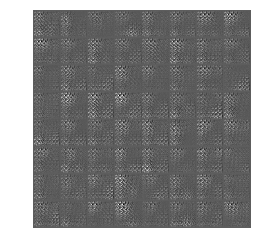

(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)
(64, 28, 28, 1)


KeyboardInterrupt: 

In [22]:
samples = []
for i in range(epochs):
    train_d = True
    train_g = True
    keep_prob_train = 0.6

    # Creating noise
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)
    # batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run(
        [loss_d_real, loss_d_fake, loss_g, loss_d],
        feed_dict={real_images: batch_x, noise: n, keep_prob: keep_prob_train, is_training: True}
    )
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)

    g_ls = g_ls
    d_ls = d_ls

    if g_ls * 1.5 < d_ls:
        train_g = False
        pass

    if d_ls * 2 < g_ls:
        train_d = False
        pass
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, real_images: batch_x, keep_prob: keep_prob_train, is_training:True})
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
    # Showing sample image
    if not i % 50:
        gen_sample = sess.run(g, feed_dict={noise: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,0] for img in gen_sample]
        m = montage(imgs)
        gen_sample = m
        plt.axis('off')
        plt.imshow(gen_sample, cmap='gray')
        plt.show()